In [1]:
# import relevant libraries for simulation
import matplotlib.pyplot as plt
from random import randint
import scipy.stats as st
import networkx as nx
import numpy as np
import random
import heapq

In [2]:
def find_weights(f_node, s_node):
    """
    In the waste removal model, the road system connects
    farms, the waste removal company, and the waste drop-off sites.
    
    This function takes two nodes on this model and 
    returns the weight between them.
    """
    # takes the weight to be from the assigned value of the nodes
    return farm_sites_dict[f_node] + farm_sites_dict[s_node]

def waste_production_rate(node_chosen):
    """
    In the waste removal model, different farms have different
    average rates of waste production, so there will be more waste
    on some days than other days.
    
    This function obtains rate of waste production
    """
    # determine and initial value for the amount of waste production
    waste_production = 0.25
    
    # waste produced related to population at nodes (increases/decreases based on population) 
    waste_produced = (node_population[node_chosen]/1000) * waste_production
    
    return 60/waste_produced

def drop_off_sites(network, no_sites):
    """
    In the waste removal model, the waste drop-off sites can be in
    different geographical spaces. For this model, we can determine the
    locations of the drop-off sites.
    
    This function determines a location for the drop-off site 
    at random positions in the network
    """
    distribution = {}
    
    nodes = list(network.nodes())
    
    for i in range(no_sites):
        position = random.choice(nodes) # chooses a node from network
        nodes.remove(position)
        distribution[position] = True # establishes a certain node with a drop-off site

    for i in range(len(nodes)):
        position = random.choice(nodes)
        nodes.remove(position)
        distribution[position] = False # determines that there are no drop-off sites in node

    return distribution

In [3]:
# nodes here include the farm sites (that may or may not
# contain a drop-off site) connected in the network
farm_nodes = ["farm-alpha", "farm-beta", "farm-gamma", "farm-delta", 
              "farm-epsilon", "farm-zeta", "farm-omicron", 
              "farm-sigma", "farm-omega", "farm-theta",
              "farm-kappa", "farm-lambda", "farm-bernoulli"]

# assigned values to the nodes in the network
farm_sites_dict = {"farm-alpha": 0.88, "farm-beta": 1.95,
                   "farm-gamma": 1.02, "farm-delta": 2.12,
                   "farm-epsilon": 1.69, "farm-zeta": 3.49,
                   "farm-omicron": 0.67, "farm-sigma": 1.43,
                   "farm-omega": 0.70, "farm-theta": 2.76,
                   "farm-kappa": 1.18, "farm-lambda": 1.79,
                   "farm-bernoulli": 1.27}

node_population = {"farm-alpha": 12366, "farm-beta": 4017895,
                   "farm-gamma": 25290, "farm-delta": 347104,
                   "farm-epsilon": 4460, "farm-zeta": 571202,
                   "farm-omicron": 3192, "farm-sigma": 33198,
                   "farm-omega": 307213, "farm-theta": 26624,
                   "farm-kappa": 143156, "farm-lambda": 3161,
                   "farm-bernoulli": 1143}

# connected farms represent farms that have a direct connection between each other
# in other words, there is an edge between these nodes
connected_farms = [["farm-alpha", "farm-beta"], ["farm-beta", "farm-gamma"],
                   ["farm-beta", "farm-delta"], ["farm-beta", "farm-epsilon"],
                   ["farm-gamma", "farm-delta"], ["farm-gamma", "farm-zeta"], 
                   ["farm-delta", "farm-epsilon"], ["farm-delta", "farm-zeta"],
                   ["farm-epsilon", "farm-omicron"], ["farm-epsilon", "farm-sigma"],
                   ["farm-zeta", "farm-omicron"], ["farm-zeta", "farm-bernoulli"],
                   ["farm-zeta", "farm-theta"], ["farm-omicron", "farm-bernoulli"],
                   ["farm-omicron", "farm-omega"], ["farm-sigma", "farm-omega"],
                   ["farm-omega", "farm-lambda"], ["farm-theta", "farm-bernoulli"],
                   ["farm-theta", "farm-kappa"], ["farm-bernoulli", "farm-kappa"],
                   ["farm-lambda", "farm-kappa"]]

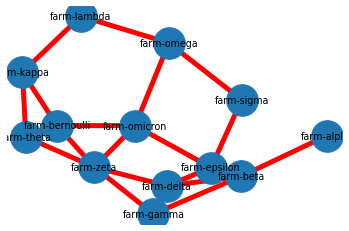

In [4]:
# use networkx to create graphs of farm sites
farm_sites = nx.Graph()

# add edges between nodes from the previously made dictionaries
for farm in connected_farms:
    farm_sites.add_edge(farm[0], farm[1], weight = find_weights(farm[0], farm[1]))

# include attributes of each of the nodes in the network
for node in farm_sites.nodes():
    farm_sites.nodes[node]['population'] = node_population[node]
    farm_sites.nodes[node]['weight'] = farm_sites_dict[node]
    farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
    farm_sites.nodes[node]['waste_truck'] = random.choice([True, False])

# plotting the farm sites graph
pos = nx.spring_layout(farm_sites) 
# draw the nodes of respective farm sites
nx.draw_networkx_nodes(farm_sites, pos, node_size = 1000)
# draw the edges of the network
nx.draw_networkx_edges(farm_sites, pos, width = 5, edge_color = "r")
# include labels for the sites
nx.draw_networkx_labels(farm_sites, pos, font_size = 9.5, font_family = "sans-serif")
plt.axis("off")
plt.show()

In [5]:
class Event:
    '''
    A class that handles Events and important
    aspects such as including time that they take place
    '''
    def __init__(self, timestamp, function, *args, **kwargs):

        # variables for the timestamp of the event
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        
        '''
        To determine the schedule of events and the order. The events have
        timestamps to help determine this order.
        '''
        
        # determines boolean value to have an event set
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        To run the event given the parameters 
        '''
        # runs the function with params passed
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    A class that handles the schedule of the events, it organizes
    and selects the events. Helps create events and finding other events.
    Tracks the time of the simulation.
    '''
    
    def __init__(self):
        
        # time of simulation
        self.now = 0

        # to hold the events in the schedule
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):

        # add event and push to the queue of events
        heapq.heappush(self.priority_queue, Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        
        # add event to schedule after interval period
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        
        # next event in the queue
        return self.priority_queue[0].timestamp

        # try:
        #     return self.priority_queue[0].timestamp
        # except IndexError:
        #     pass

    def run_next_event(self):
        
        # run simulation and update time
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        
        # returns representation of simulation
        return (f'Schedule() at time {self.now} ' + f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):

        # printing events in schedule
        print(repr(self))
        
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [6]:
class WasteRemovalNetwork: 
    """
    In the waste removal model, the waste removal company has trucks that
    visit the farms (nodes in the network), collect waste and drop-off

    This WasteRemovalNetwork class handles the different processes in the model
    """
    
    def __init__(self, network, printing = False):

        # the network of nodes of different farmsites 
        self.network = network

        # the waste truck collection determines the process of the waste trucks
        self.waste_truck_collection = 2

        # keep the time it takes to collect waste at different nodes 
        self.waste_collection_time = []

        # determines the quantity of waste to collect
        self.waste_to_collect = 0

        # the waste truck take on average this amount of time to collect waste
        self.collection_time_mean = 25

        # the waste truck time can vary by some measure of standard deviation
        self.collection_time_std = 5

        # introduce more probabilistic randomness into the time to collect 
        self.additional_time_mean = 5
        self.additional_time_std = 2
        self.probabilistic_randomness = 30

        # the waste truck might have to drive to another farm
        self.collection_queue = []

        # determines the drop off site for a waste truck
        self.drop_off_site = []

        # determines the length of the queue for waste collection
        self.length_of_queue = []

        # this determines status of the drop off site 
        self.drop_off_available = []

        # boolean, can be changed between True and False, default is False
        self.printing = printing
    
        # determines if there is a drop off site based on availability of waste trucks
        for farm_site in farm_sites.nodes():
            if self.network.nodes[farm_site]['waste_truck']:
                self.drop_off_site.append(farm_site)
    
    def begin_waste_collection(self, schedule, initial_farm_node, final_farm_node):
        """
        In this model, the waste collection process begins after the params are such
        that the node requires the waste to be collected
        """
        # the printing variable is boolean that can be True or False
        if self.printing:
            print(f"Waste collection from truck at {initial_farm_node} to collect at {final_farm_node}")
        
        # counter for nodes where there is waste to collect increase 
        self.waste_to_collect += 1

        # the node is removed from available dropp_off_sites 
        try:
            self.drop_off_site.remove(initial_farm_node)
        except ValueError:
            pass

        # self.drop_off_site.remove(initial_farm_node)
        self.network.nodes[initial_farm_node]['waste_truck'] = False
        
        # include probabilistic randomness introduced by additional time 
        include_additional_time = 0

        # to determine if additional time is needed, choose randint 
        if randint(0, 100) <= self.probabilistic_randomness:
            
            # determine additional time from normally distributed values
            include_additional_time = np.random.normal(self.additional_time_mean, self.additional_time_std)
        
        # the collection_time is the total time it takes to collect the waste at a node
        collection_time = np.random.normal(self.collection_time_mean, self.collection_time_std)
        calculated_time_of_arrival = self.time_of_arrival(initial_farm_node, final_farm_node)*2 
        total_collection_time = calculated_time_of_arrival + collection_time + include_additional_time
        self.waste_collection_time.append(self.time_of_arrival(initial_farm_node, final_farm_node)*2)
        
        # schedule event to be added
        schedule.add_event_after(total_collection_time, self.finish_waste_collection, initial_farm_node)
        
    def finish_waste_collection(self, schedule, initial_node): 
        """
        In this model, the waste collection process finishes after the waste truck
        has arrived at the node that required the waste to be collected
        """

        # the node is an available drop-off site
        self.network.nodes[initial_node]['waste_truck'] = True
        self.drop_off_site.append(initial_node)

        # the nodes that are available for drop-off waste
        self.drop_off_available.append(len(self.drop_off_site))
        
        # if there are more nodes to visit to collect waste
        if len(self.collection_queue) > 0:
            schedule.add_event_after(0, self.begin_waste_collection, 
                                     initial_farm_node = initial_node, 
                                     final_farm_node = self.collection_queue.pop())
        
    def order_waste_collection(self, schedule, final_farm_node): 
        """
        In this model, the waste collection process begins when it is ordered
        through this function in the model
        """
        
        if self.printing:
            print(f"Waste collection ordered at the {final_farm_node} farm!!")
            
        # determines if the drop-off site is available
        if len(self.drop_off_site) != 0:
            
            min_length = float("inf")
            min_length_site = None

            for site in self.drop_off_site:
                length = nx.shortest_path_length(self.network, source = site, 
                                                 target = final_farm_node, 
                                                 weight = 'weight')
                if length < min_length:
                    min_length = length
                    min_length_site = site
            
            # schedule an event
            schedule.add_event_after(0, self.begin_waste_collection, 
                                     initial_farm_node = min_length_site, 
                                     final_farm_node = final_farm_node)
        else: 

            # add the site to the queue
            self.collection_queue.append(final_farm_node)

        self.length_of_queue.append(len(self.collection_queue))

    def schedule_waste_collection(self, schedule, final_farm_node):
        """
        Determines the time for the next waste collection that is needed
        """
        self.order_waste_collection(schedule, final_farm_node)
        schedule.add_event_after(np.random.normal(self.network.nodes[final_farm_node]["waste_rate"], 2) + random.random(), self.schedule_waste_collection, final_farm_node)

    
    def time_of_arrival(self, initial_farm_node, final_farm_node):
        """
        Using this we find the time of arrival from the waste collection truck to the site
        """
        distance = nx.shortest_path_length(self.network, source = initial_farm_node,
                                           target = final_farm_node, weight = 'weight')
        
        return distance * self.waste_truck_collection
    
    def start_simulation(self, schedule):
        """
        Starts the simulation with an initial waste collection
        """
        for farm_site in self.network.nodes():
            time = np.random.poisson(self.network.nodes[farm_site]["waste_rate"])
            schedule.add_event_after(time + random.random(), self.schedule_waste_collection, farm_site)
    
    def print_status(self):
        print(f"Drop off site: {self.drop_off_site}")
        print(f"Waste collection queue: {self.collection_queue}")
        print(f"Number of sites to collect waste: {self.waste_to_collect}")

In [7]:
def run_waste_simulation(network, run_until = 100, re_print = False): 
    """
    Running the simulation with the given parameters
    """
    # instantiating the classes 
    schedule = Schedule()
    waste_collection_process = WasteRemovalNetwork(network, re_print)
    waste_collection_process.start_simulation(schedule)
    
    # running simulation
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()

        if re_print:
            print(schedule)
            waste_collection_process.print_status()
            print("\n")

    return waste_collection_process

In [8]:
# test that simulation runs as expected
farm_sites = nx.Graph()

for edge in connected_farms:
    farm_sites.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))

# determines drop-off sites
dis = drop_off_sites(farm_sites, 6)

for node in farm_sites.nodes():
    farm_sites.nodes[node]['population'] = node_population[node]
    farm_sites.nodes[node]['area'] = farm_sites_dict[node]
    farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
    farm_sites.nodes[node]['waste_truck'] = dis[node]
            
run_waste_simulation(farm_sites, run_until = 100, re_print = True)

Waste collection ordered at the farm-zeta farm!!
Schedule() at time 0.6073863447470114 with 14 events in the queue
Drop off site: ['farm-alpha', 'farm-gamma', 'farm-delta', 'farm-omicron', 'farm-sigma', 'farm-bernoulli']
Waste collection queue: []
Number of sites to collect waste: 0


Waste collection from truck at farm-omicron to collect at farm-zeta
Schedule() at time 0.6073863447470114 with 14 events in the queue
Drop off site: ['farm-alpha', 'farm-gamma', 'farm-delta', 'farm-sigma', 'farm-bernoulli']
Waste collection queue: []
Number of sites to collect waste: 1


Waste collection ordered at the farm-beta farm!!
Schedule() at time 0.7708810301969136 with 15 events in the queue
Drop off site: ['farm-alpha', 'farm-gamma', 'farm-delta', 'farm-sigma', 'farm-bernoulli']
Waste collection queue: []
Number of sites to collect waste: 1


Waste collection from truck at farm-alpha to collect at farm-beta
Schedule() at time 0.7708810301969136 with 15 events in the queue
Drop off site: ['farm-g

In [9]:
# initialize values of interest on the simulation
average_service_time = []
average_queue_len=[]
best_number_of_stations = 12

# loops to represent the numerous trials
for i in range(1000):
    
    # reset the network
    farm_sites = nx.Graph()
    for edge in connected_farms:
        farm_sites.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))
    
    # get a random distribution for the stations
    dis = drop_off_sites(farm_sites, best_number_of_stations)
    
    for node in farm_sites.nodes():
        farm_sites.nodes[node]['population'] = node_population[node]
        farm_sites.nodes[node]['area'] = farm_sites_dict[node]
        farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
        farm_sites.nodes[node]['waste_truck'] = dis[node]
        
    # save the output variables
    out = run_waste_simulation(farm_sites, run_until=1000)
    average_service_time.append(np.mean(out.waste_collection_time))
    average_queue_len.append(np.mean(out.length_of_queue))

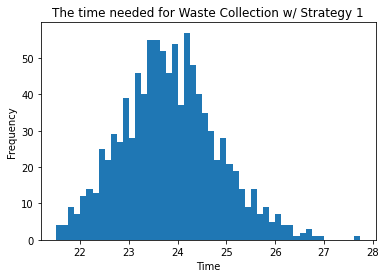

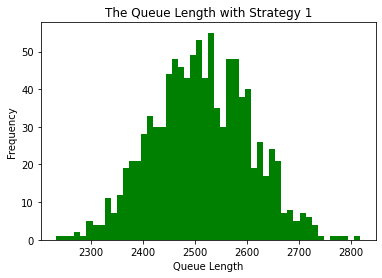

Average time needed for the average strategy: 23.848184204235302
Average time needed 95% confidence interval (23.8079831312574, 23.888385277213203)
Average queue length: 2512.411927658518
Average queue length 95% confidence interval (2508.6301795185045, 2516.1936757985313)


In [10]:
# plot the results and get the confidence interval
plt.hist(average_service_time, bins = 50)
plt.title("The time needed for Waste Collection w/ Strategy 1")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

plt.hist(average_queue_len, bins = 50, color = 'green')
plt.title("The Queue Length with Strategy 1")
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

average_def_strat_que = np.mean(average_queue_len)
average_def_strat_time = np.mean(average_service_time)

print(f"Average time needed for the average strategy: {np.mean(average_service_time)}")
print(f"Average time needed 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_service_time) - 1, loc = np.mean(average_service_time), scale = st.sem(average_service_time)) }")
print(f"Average queue length: {np.mean(average_queue_len)}")
print(f"Average queue length 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_queue_len) - 1, loc = np.mean(average_queue_len), scale = st.sem(average_queue_len)) }")

In [11]:
# find the nodes with highest degree considering weights
order = sorted(farm_sites.degree(weight = "weight"), key = lambda x: x[1], reverse = True)
best_distribution = {}
nodes = list(farm_sites.nodes())

for i in range(best_number_of_stations):
    spot = order[i][0]
    nodes.remove(spot)
    best_distribution[spot] = True
    
for node in nodes:
    best_distribution[node] = False# ini

In [12]:

average_service_time = []
average_queue_len = []

# run the simulation for 1000 trials
for i in range(1000):
    
    # reset the network with the best distribution
    farm_sites = nx.Graph()
    
    for edge in connected_farms:
        farm_sites.add_edge(edge[0], edge[1], weight=find_weights(edge[0], edge[1]))
        
    for node in farm_sites.nodes():
        farm_sites.nodes[node]['population'] = node_population[node]
        farm_sites.nodes[node]['area'] = farm_sites_dict[node]
        farm_sites.nodes[node]['waste_rate'] = waste_production_rate(node)
        farm_sites.nodes[node]['waste_truck'] = dis[node]

    # save the results
    out = run_waste_simulation(farm_sites, run_until=1000)
    average_service_time.append(np.mean(out.waste_collection_time))
    average_queue_len.append(np.mean(out.length_of_queue))

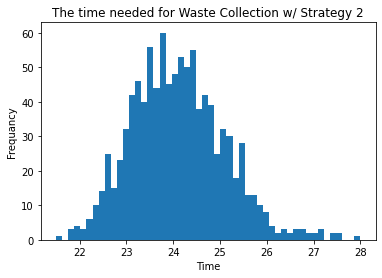

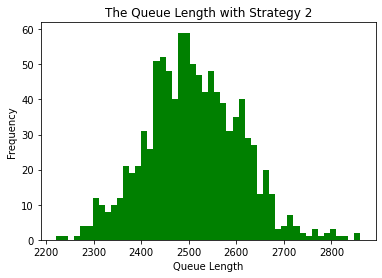

Average time needed for the proposed strategy: 24.103494688864792
Average time needed 95% confidence interval (24.063333167472056, 24.14365621025753)
Average queue length: 2509.9640178902796
Average queue length 95% confidence interval (2505.9562562191727, 2513.9717795613865)


In [13]:
# plot the results and find the confidence interval
plt.hist(average_service_time, bins=50)
plt.title("The time needed for Waste Collection w/ Strategy 2")
plt.xlabel('Time')
plt.ylabel('Frequancy')
plt.show()

plt.hist(average_queue_len, bins=50, color='green')
plt.title("The Queue Length with Strategy 2")
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.show()

average_pro_strat_que = np.mean(average_queue_len)
average_pro_strat_time = np.mean(average_service_time)

print(f"Average time needed for the proposed strategy: {np.mean(average_service_time)}")
print(f"Average time needed 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_service_time) - 1, loc = np.mean(average_service_time), scale = st.sem(average_service_time)) }")
print(f"Average queue length: {np.mean(average_queue_len)}")
print(f"Average queue length 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_queue_len) - 1, loc = np.mean(average_queue_len), scale = st.sem(average_queue_len)) }")